In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback

Using TensorFlow backend.


In [49]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
df_true.head()
df_true['category'] = 1
df_fake['category'] = 0
df = pd.concat([df_true,df_fake])

In [52]:
batch_size = 256
epochs = 10
embed_size = 128
max_features = 10000
maxlen = 300

In [53]:
df['text'] = df['title'] + df['text'] + df['subject']
X_train,X_test,y_train,y_test = train_test_split(df.text,df.category, test_size = 0.20)

t = Tokenizer(num_words = vocab_size)
t.fit_on_texts(X_train)
train_sequences = t.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=maxlen,
                                padding=padding_type,
                                truncating=trunc_type)
t.fit_on_texts(X_test)
test_sequences = t.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=maxlen,
                                padding=padding_type,
                                truncating=trunc_type)

train_padded = np.array(train_padded)
y_train = np.array(y_train)

In [54]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
import gensim

w2v_model = gensim.models.Word2Vec(sentences=X, size=embed_size, window=5, min_count=1)

In [56]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
obama -> 8
new -> 9
clinton -> 10


In [57]:
X = pad_sequences(X, maxlen=maxlen)

In [58]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

159774

In [61]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, embed_size))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [62]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

C:\Users\emu4y\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [69]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=embed_size, input_length=maxlen, weights = [embedding_vectors],trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > 0.95:
                print(f'Accuracy reached {logs.get("acc")*100:0.2f}. Stopping the training')
                self.model.stop_training = True

accuracyhist = AccuracyHistory()


In [79]:
history = model.fit(train_padded, y_train, batch_size = batch_size , validation_data = (test_padded,y_test) , epochs = epochs , callbacks = [accuracyhist])

Train on 35918 samples, validate on 8980 samples
Epoch 1/10
35918/35918 [==============================] - 3432s 96ms/step - loss: 0.3827 - accuracy: 0.8323 - val_loss: 0.3909 - val_accuracy: 0.8476
Epoch 2/10
35918/35918 [==============================] - 3457s 96ms/step - loss: 0.2700 - accuracy: 0.9004 - val_loss: 0.3104 - val_accuracy: 0.8957
Epoch 3/10
35918/35918 [==============================] - 3226s 90ms/step - loss: 0.1733 - accuracy: 0.9400 - val_loss: 0.3325 - val_accuracy: 0.9112
Epoch 4/10
35918/35918 [==============================] - 3650s 102ms/step - loss: 0.1349 - accuracy: 0.9547 - val_loss: 0.5668 - val_accuracy: 0.8156
Epoch 5/10
35918/35918 [==============================] - 3566s 99ms/step - loss: 0.1385 - accuracy: 0.9504 - val_loss: 0.2496 - val_accuracy: 0.9332
Epoch 6/10
35918/35918 [==============================] - 3643s 101ms/step - loss: 0.0402 - accuracy: 0.9898 - val_loss: 0.2677 - val_accuracy: 0.9326
Epoch 7/10
35918/35918 [=========================

In [86]:
y_pred = (model.predict(test_padded) > 0.5).astype("int")

In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4716
           1       0.99      0.88      0.93      4264

    accuracy                           0.94      8980
   macro avg       0.95      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



In [80]:
model.save("FakeNewsDetector9958.h5")

In [88]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 128)          20451072  
_________________________________________________________________
lstm_15 (LSTM)               (None, 300, 128)          131584    
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 20,634,177
Trainable params: 183,105
Non-trainable params: 20,451,072
_________________________________________________________________


In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(cm, index = ['Real', 'Fake'], columns = ['Predicted Real', 'Predicted Fake'])
confusion

,Predicted Real,Predicted Fake
Real,4682,34
Fake,519,3745


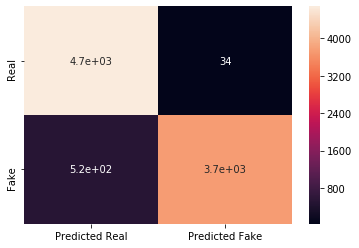

In [90]:
sns.heatmap(confusion,annot=True)

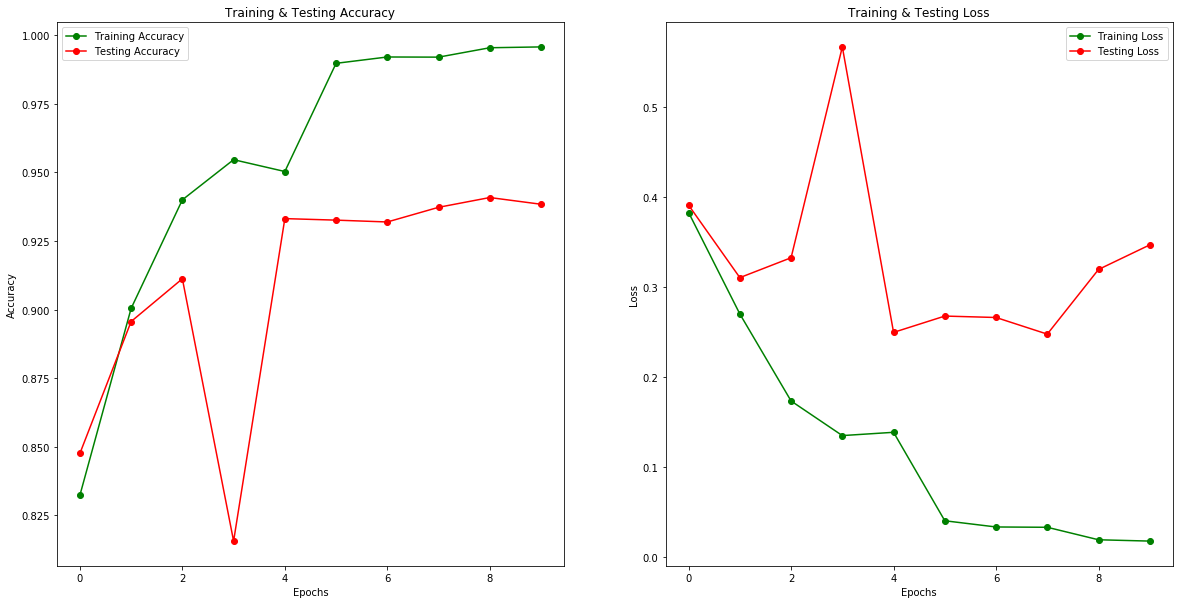

In [91]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()